### Tutorial Notebook Showing How sus, infoenginessims work together to make a sim object

In [1]:
#standard imports, these can be done automatically using a conda environemnt
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
# imports to deal with getting nice animations and outputs for matplotlip in jupyter
plt.rcParams["animation.html"] = "jshtml"
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline

from info_space import separate_by_state
from measure import binary_partition
from importlib import reload  # Python 3.4+
import helpingTools
import kyle_tools as kt
helpingTools = reload(helpingTools)


In [2]:
# I always keep my code in a folder in my home directory called 'source/', and begin with the following:
source_path = os.path.expanduser('~/Project/source/')
sys.path.append(source_path)
# which will enable the following imports:
from sus import protocol_designer as pd
from sus.library.szilard_protocols import blw_szilard

# usually these would not be imported but handled in a separate document, but to show the inner workings 
# of the simtools package, I will manually import some stuff

sim_path = os.path.dirname(source_path + "simtools/infoenginessims/")
sys.path.append(sim_path)

from integrators import rkdeterm_eulerstoch
from dynamics import langevin_underdamped, langevin_overdamped
from simprocedures import basic_simprocedures as sp
from simprocedures import running_measurements as rp
from simprocedures import edward_simprocedures as ep
from simulation import Simulation

In [3]:
def showGIF(item):     
    filename = f"parameter/animation_ts_{item['ts']}_damping_{item['damping']}" + \
               f"_parameter_{item['gamma']},{item['theta']},{item['eta']}_times.gif"
    print(filename)
    print(f"time stretch = {item['ts']}, damping = {item['damping']}, " + \
               f"gamma = {item['gamma']}, theta = {item['theta']}, eta = {item['eta']}")
    for _key, _item in item["statistics"].items():
        print(f"{_key} ({colorMapping[_key]}): {_item}")
    display(Image(url=filename))


In [4]:
# first, we have our system, as explained in the sus package tutorial:
system = blw_szilard
# init_state = system.eq_state(10_000, 0, beta=1)
init_state = system.eq_state(4, 0, beta=1)

 found 8 samples out of 4

In [25]:
import helpingTools
helpingTools = reload(helpingTools)
ep = reload(ep)

gamma, theta, eta = 1, 1, 1
dynamic = langevin_underdamped.LangevinUnderdamped(theta, gamma, eta, system.get_external_force)
dynamic.mass = system.mass

integrator = rkdeterm_eulerstoch.RKDetermEulerStoch(dynamic)

procedures = [
            sp.ReturnFinalState(),
            sp.MeasureAllState(trial_request=slice(0, 300)),
#             sp.MeasureAllState(),
#             sp.MeasureStepValue(ep.get_statistics_for_all_categories, "all_statistic_with_time"),
            sp.MeasureStepValue(helpingTools.get_statistics_for_all_categories, "all_statistic_with_time"),
            rp.MeasureAllValue(rp.get_dW, 'all_W'), 
            rp.MeasureFinalValue(rp.get_dW, 'final_W')]

dt = .005
# dt = .05
nsteps = int(system.protocol.t_f/dt)
sim = Simulation(integrator.update_state, procedures, nsteps, dt, initial_state=init_state)

# and associate the system with it, for future reference
sim.system = system

#Now this is all set up, we can run a simulation:
sim.output = sim.run(verbose=True)

all_state = sim.output.all_state['states']
final_state = sim.output.final_state
final_W = sim.output.final_W
all_W = sim.output.all_W

[[[ 1.19561184 -1.1792399 ]
  [ 1.74909664 -0.18426104]]

 [[-1.3528314   0.82886335]
  [ 1.35967821 -0.91364705]]

 [[-0.8672898  -1.02853598]
  [-1.31627023  1.03704579]]

 [[ 1.66099387 -0.15816477]
  [ 0.94579984  0.99324007]]]
[[[ 1.19561184 -1.1792399 ]
  [ 1.74909664 -0.18426104]]

 [[-1.3528314   0.82886335]
  [ 1.35967821 -0.91364705]]

 [[-0.8672898  -1.02853598]
  [-1.31627023  1.03704579]]

 [[ 1.66099387 -0.15816477]
  [ 0.94579984  0.99324007]]] (4, 2, 2)
[[[ 1.19561184 -1.1792399 ]
  [ 1.74909664 -0.18426104]]

 [[-1.3528314   0.82886335]
  [ 1.35967821 -0.91364705]]

 [[-0.8672898  -1.02853598]
  [-1.31627023  1.03704579]]

 [[ 1.66099387 -0.15816477]
  [ 0.94579984  0.99324007]]]
[[[ 1.19561184 -1.1792399 ]
  [ 1.74909664 -0.18426104]]

 [[-1.3528314   0.82886335]
  [ 1.35967821 -0.91364705]]

 [[-0.8672898  -1.02853598]
  [-1.31627023  1.03704579]]

 [[ 1.66099387 -0.15816477]
  [ 0.94579984  0.99324007]]] (4, 2, 2)
 step 84 of 200 complete

/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 step 200 of 200 complete

In [20]:
dim = init_state.shape[1]
ntrial = init_state.shape[0]
print(dim, ntrial)
category_list =  [(0, 0), (0, 1), (1, 0), (1, 1)]
category_label = ["00", "01", "10", "11"]

# for index, category in enumerate(category_list):
#     # fill up the bool_list
#     bool_list[category_label[index]] = np.all(measure_data == category, axis = 1)
bool_list = {"00": [], "01": [], "10": [], "11": []}

2 4


In [23]:
init_state[:, :, 0]

array([[ 1.19561184,  1.74909664],
       [-1.3528314 ,  1.35967821],
       [-0.8672898 , -1.31627023],
       [ 1.66099387,  0.94579984]])

In [ ]:
for index, category in enumerate(category_list):
    # fill up the bool_list
    measure_data = binary_partition(position_data[:, 0, :, 0]) == category
    # reshape the data from (ntrial, 1, 2) -> (ntrial, 2)
    reshaped_measure_data = measure_data.reshape(ntrials, 2)
    index_column = [x[0] and x[1] for x in reshaped_measure_data]
    bool_list[category_label[index]] = index_column


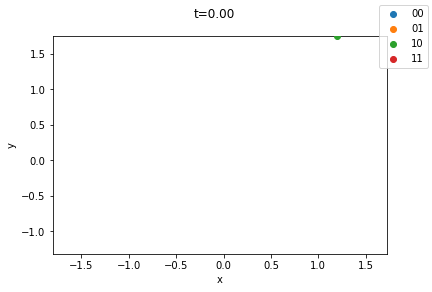

In [26]:
ani,_,_ = kt.animate_sim(all_state, frame_skip=1, color_by_state=True)


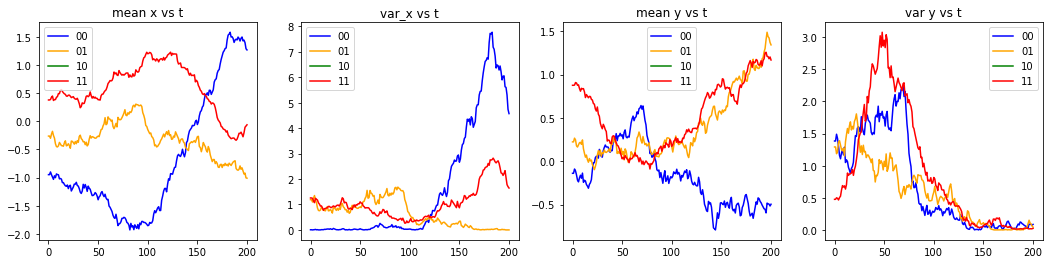

In [27]:
helpingTools.plotStatisticsChangingWithTime(sim.output.all_statistic_with_time["step_indices"], \
                                           sim.output.all_statistic_with_time["values"], None)

HTML(ani.to_jshtml(fps=10))


In [62]:
# all trials at time = 0
sim.output.all_state["states"][0:2,0]

array([[[ 1.08929656,  0.29778949],
        [ 1.60421694,  1.02163459]],

       [[-1.63561639, -0.77826944],
        [ 0.74565183, -0.31015135]]])

In [55]:
binary_partition(sim.output.all_state["states"][:,0,...])

array([[[1., 1.],
        [1., 1.]],

       [[0., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 1.]],

       ...,

       [[0., 0.],
        [1., 0.]],

       [[0., 1.],
        [1., 0.]],

       [[0., 0.],
        [1., 0.]]])

In [51]:

binary_partition(sim.output.all_state["states"][0])

array([[[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 0.]],

       [[1., 1.],
        [1., 0.]],

       [[1.,

In [47]:
sim.position_categories_index_dict.items()

dict_items([('00', array([[False, False],
       [False,  True],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False,  True]])), ('01', array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [False, False]])), ('10', array([[ True, False],
       [False,  True],
       [ True, False],
       ...,
       [ True, False],
       [ True, False],
       [False,  True]])), ('11', array([[ True,  True],
       [False, False],
       [ True, False],
       ...,
       [ True,  True],
       [ True, False],
       [False, False]]))])

In [28]:
import json

time_dependent_statistic =  sim.output.all_statistic_with_time

# to massage the statistics output so that they can be converted into json

time_dependent_statistic.pop('trial_indices', None)
time_dependent_statistic["step_indices"] = list(time_dependent_statistic["step_indices"]) # convert the slice object into a list
time_dependent_statistic["values"] = np.round(time_dependent_statistic["values"], 4).tolist() # convert a numpy object into a list

json.dumps(sim.output.all_statistic_with_time)

'{"step_indices": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

In [24]:
fileName = [x.split("_") for x in os.listdir("./parameter/") if x.endswith(".gif")]
parameterList = list(map(lambda x: (float(x[2]), float(x[4]), \
                                    [float(y) for y in x[6].replace(".gif", "").split(",")]), fileName))
print(parameterList)

[(6.0, 1.0, [4.0, 80.0, 10.0]), (8.0, 1.0, [4.0, 80.0, 10.0]), (4.0, 1.0, [4.0, 80.0, 10.0]), (2.0, 1.0, [4.0, 80.0, 10.0]), (14.0, 1.0, [4.0, 80.0, 10.0]), (20.0, 1.0, [4.0, 80.0, 10.0]), (18.0, 1.0, [4.0, 80.0, 10.0]), (16.0, 1.0, [4.0, 80.0, 10.0]), (12.0, 1.0, [4.0, 80.0, 10.0]), (10.0, 1.0, [4.0, 80.0, 10.0])]


In [12]:
def rerunAllTheSimulations(parameterList):
    for x in parameterList:
        runSimulationFunction(x, overwrite=True)


# time stretch sweep

In [28]:
sweepObject = {
    "_time_stretch": [float(x) for x in range(2, 22, 2)],
    "_damping": 1,
    "_gamma": 4, 
    "_theta": 80, 
    "_eta": 10
}

label="time_stretch_sweep"
print(sweepObject)

{'_time_stretch': [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0], '_damping': 1, '_gamma': 4, '_theta': 80, '_eta': 10}


========== start (1/10) ==========
time_stretch: 1, _damping: 1.0, _gamma: 4, _theta: 80, _eta: 10
[<simprocedures.basic_simprocedures.ReturnFinalState object at 0x7fbfb7ea0a90>, <simprocedures.basic_simprocedures.MeasureAllState object at 0x7fbfb7ea0640>, <simprocedures.basic_simprocedures.MeasureStepValue object at 0x7fbfb7ea0b80>, <simprocedures.running_measurements.MeasureAllValue object at 0x7fbfb7ea0880>, <simprocedures.running_measurements.MeasureFinalValue object at 0x7fbfb7ea0910>]
 step 200 of 200 complete<simprocedures.basic_simprocedures.ReturnFinalState object at 0x7fbfb7ea0a90>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'all_W', 'all_state', 'all_statistic_with_time', 'final_

TypeError: Object of type range is not JSON serializable

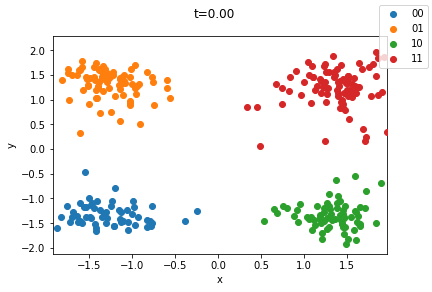

In [35]:
# import helpingTools
helpingTools = reload(helpingTools)
helpingTools.sweepFunction(sweepObject, system, init_state, procedures = procedures, label=label, save=True, overwrite=False, speedyRun = False)



# Damping Sweep

In [29]:
sweepObject = {
    "_time_stretch": 1,
    "_damping": [float(x) for x in np.linspace(1, 10, 10)],
    "_gamma": 4, 
    "_theta": 80, 
    "_eta": 10
}

label="damping_sweep"

========== start (1/10) ==========
time_stretch: 1, _damping: 1.0, _gamma: 4, _theta: 80, _eta: 10
[<simprocedures.basic_simprocedures.ReturnFinalState object at 0x7fa82a4dcd90>, <simprocedures.basic_simprocedures.MeasureAllState object at 0x7fa82a4dcdf0>, <simprocedures.basic_simprocedures.MeasureStepValue object at 0x7fa82a4dcfa0>, <simprocedures.running_measurements.MeasureAllValue object at 0x7fa82a4dcd30>, <simprocedures.running_measurements.MeasureFinalValue object at 0x7fa96f19d910>]
 step 2000 of 2000 complete00 < 0
number of good points:  56
key: 00 (blue) = 88.88888888888889
mean: -1.002501845711853, var: 0.8652675601776408
01 < 0
number of good points:  84
key: 01 (orange) = 87.5
mean: -1.1199973428685668, var: 0.7287693298999107
10 > 0
number of good points:  59
key: 10 (green) = 84.28571428571429
mean: 1.2143012407918523, var: 0.5167191626852805
11 > 0
number of good points:  63
key: 11 (red) = 88.73239436619718
mean: 1.2240137836348497, var: 0.3737614659279718
parameter/a

parameter/animation_ts_1_damping_6.0_parameter_4,80,10_times.gif is saved.
You are not saving data
========== finished (6/10) ==========
========== start (7/10) ==========
time_stretch: 1, _damping: 7.0, _gamma: 4, _theta: 80, _eta: 10
[<simprocedures.basic_simprocedures.ReturnFinalState object at 0x7fa82a4dcd90>, <simprocedures.basic_simprocedures.MeasureAllState object at 0x7fa82a4dcdf0>, <simprocedures.basic_simprocedures.MeasureStepValue object at 0x7fa82a4dcfa0>, <simprocedures.running_measurements.MeasureAllValue object at 0x7fa82a4dcd30>, <simprocedures.running_measurements.MeasureFinalValue object at 0x7fa96f19d910>]
 step 2000 of 2000 complete00 < 0
number of good points:  63
key: 00 (blue) = 100.0
mean: -1.1217092282598833, var: 0.26027629844891076
01 < 0
number of good points:  37
key: 01 (orange) = 38.54166666666667
mean: -1.0649971831129437, var: 0.1483748291803027
10 > 0
number of good points:  24
key: 10 (green) = 34.285714285714285
mean: 1.185283412176963, var: 0.080397

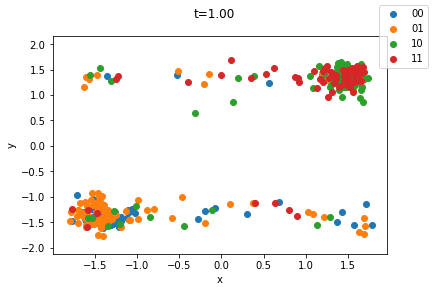

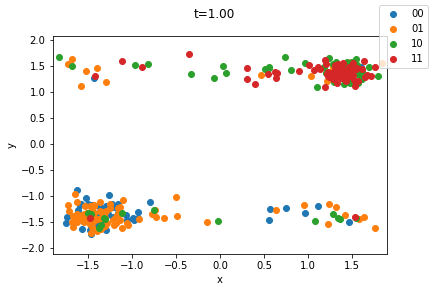

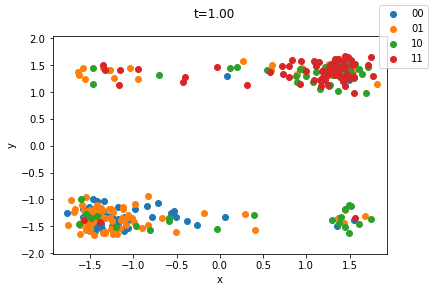

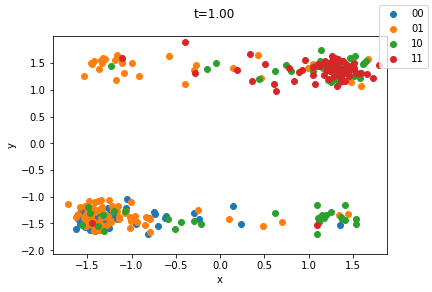

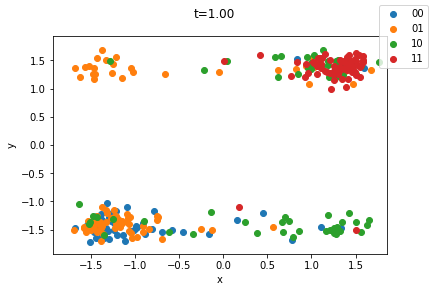

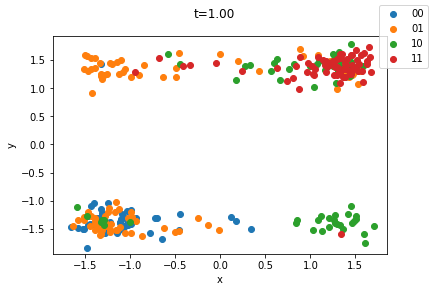

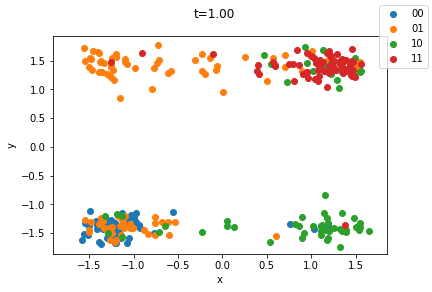

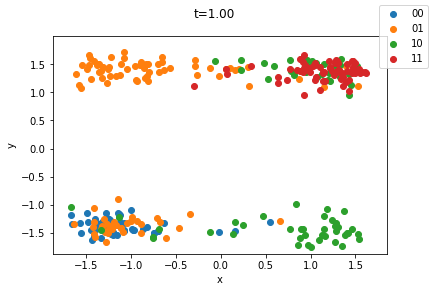

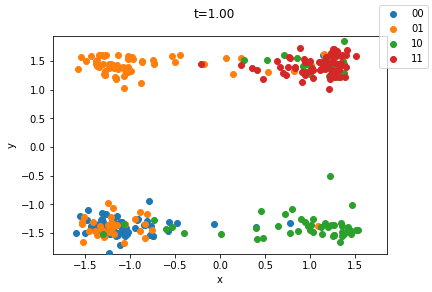

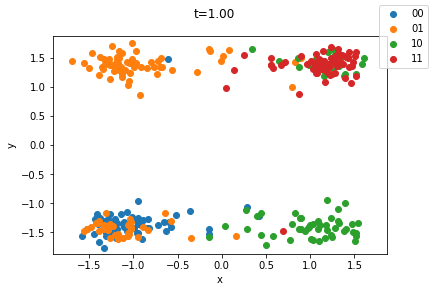

In [30]:
helpingTools = reload(helpingTools)
helpingTools.sweepFunction(sweepObject, system, init_state, procedures = procedures, label=label, save=True, overwrite=True, speedyRun = False)




# Gamma Sweep

In [53]:
sweepObject = {
    "_time_stretch": 1,
    "_damping": 1,
    "_gamma": [float(x) for x in np.linspace(0, 10, 11)], 
    "_theta": 80, 
    "_eta": 10
}

label="gamma_sweep"

In [54]:
helpingTools.sweepFunction(sweepObject, system, init_state, procedures = procedures, label=label, save=True, overwrite=False, speedyRun = False)

========== start (1/11) ==========
time_stretch: 4, _damping: 1, _gamma: 0.0, _theta: 80, _eta: 10
None
 step 800 of 800 complete

AttributeError: 'Bunch' object has no attribute 'all_statistic_with_time'

# Theta Sweep

In [22]:
sweepObject = {
    "_time_stretch": 4,
    "_damping": 1,
    "_gamma": 1, 
    "_theta": [float(x) for x in np.linspace(0, 100, 11)], 
    "_eta": 10
}

label="theta_sweep"

========== start (1/11) ==========
time_stretch: 4, _damping: 1, _gamma: 1, _theta: 0.0, _eta: 10
[<simprocedures.basic_simprocedures.ReturnFinalState object at 0x7fa96e4aca00>, <simprocedures.basic_simprocedures.MeasureAllState object at 0x7fa96e4acb50>, <simprocedures.basic_simprocedures.MeasureStepValue object at 0x7fa96e4acb80>, <simprocedures.running_measurements.MeasureAllValue object at 0x7fa96e4ac8e0>, <simprocedures.running_measurements.MeasureFinalValue object at 0x7fa96e4acc70>]
 step 8000 of 8000 complete00 < 0
number of good points:  34
key: 00 (blue) = 53.96825396825397
mean: -3.0865219229879832, var: 561.960626544339
01 < 0
number of good points:  57
key: 01 (orange) = 59.375
mean: -0.9714067621363482, var: 462.43790258116957
10 > 0
number of good points:  31
key: 10 (green) = 44.285714285714285
mean: 2.638444556552464, var: 585.5940657355061
11 > 0
number of good points:  39
key: 11 (red) = 54.929577464788736
mean: -0.493377237479199, var: 543.4604046915334
parameter/an

 step 8000 of 8000 complete00 < 0
number of good points:  39
key: 00 (blue) = 61.904761904761905
mean: 0.06847095157117646, var: 1.5048864634296302
01 < 0
number of good points:  56
key: 01 (orange) = 58.333333333333336
mean: 0.03923260951874284, var: 1.8796914657820503
10 > 0
number of good points:  40
key: 10 (green) = 57.14285714285714
mean: 0.08722433955614106, var: 1.6349272135280792
11 > 0
number of good points:  47
key: 11 (red) = 66.19718309859155
mean: 0.3839441228456035, var: 1.6037705466869054
parameter/animation_ts_4_damping_1_parameter_1,50.0,10_times.gif is saved.
You are not saving data
========== finished (6/11) ==========
========== start (7/11) ==========
time_stretch: 4, _damping: 1, _gamma: 1, _theta: 60.0, _eta: 10
[<simprocedures.basic_simprocedures.ReturnFinalState object at 0x7fa96e4aca00>, <simprocedures.basic_simprocedures.MeasureAllState object at 0x7fa96e4acb50>, <simprocedures.basic_simprocedures.MeasureStepValue object at 0x7fa96e4acb80>, <simprocedures.ru

KeyboardInterrupt: 

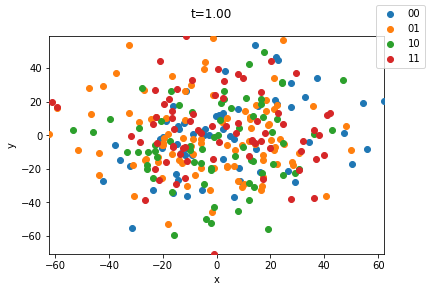

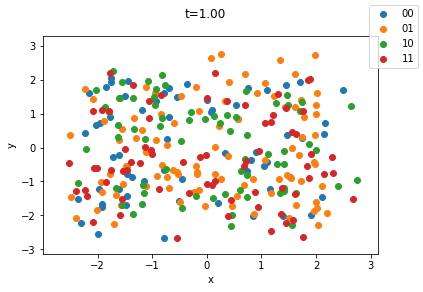

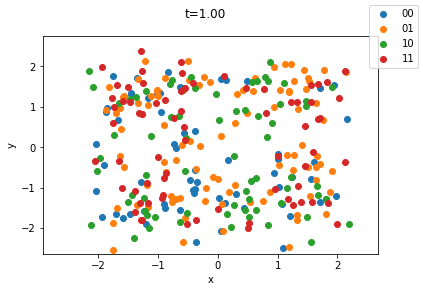

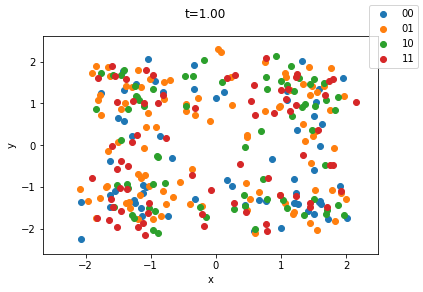

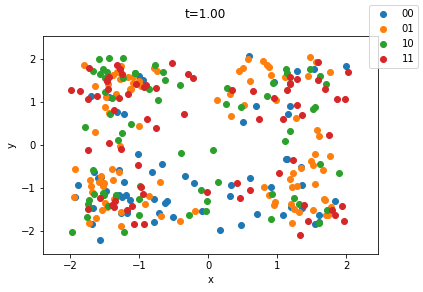

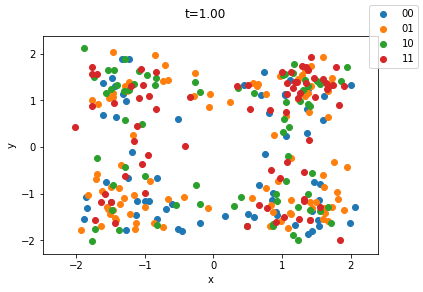

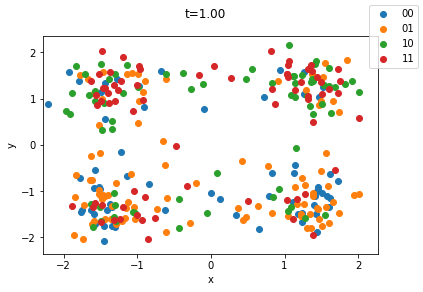

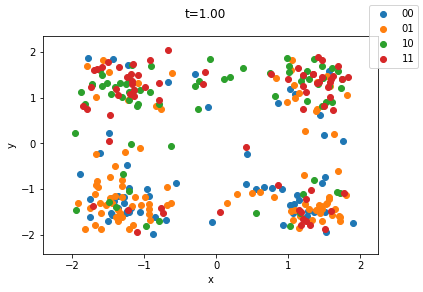

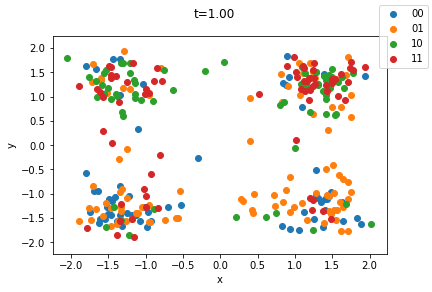

In [23]:
helpingTools.sweepFunction(sweepObject, system, init_state, procedures = procedures, label=label, save=True, overwrite=False, speedyRun = False)

# Eta Sweep

In [ ]:
sweepObject = {
    "_time_stretch": 4,
    "_damping": 1,
    "_gamma": 4, 
    "_theta": 80, 
    "_eta": [float(x) for x in np.linspace(0, 100, 11)]
}

label="eta_sweep"

In [ ]:
helpingTools.sweepFunction(sweepObject, system, init_state, procedures = procedures, label=label, save=True, overwrite=False, speedyRun = False)

# Single Simulation

time_stretch: 4, _damping: 5, _gamma: 40, _theta: 0, _eta: 10
 step 800 of 800 complete00 < 0
number of good points:  239
key: 00 (blue) = 99.58333333333333
mean: -1.312693206260281, var: 0.17090614396853698
01 < 0
number of good points:  0
key: 01 (orange) = 0.0
mean: nan, var: nan
10 > 0
number of good points:  3
key: 10 (green) = 1.090909090909091
mean: 1.2269331974008735, var: 0.18161783529387207
11 > 0
number of good points:  239
key: 11 (red) = 99.1701244813278
mean: 1.3192352466444148, var: 0.18400805097461254


/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/edwardtang/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


You are not saving data


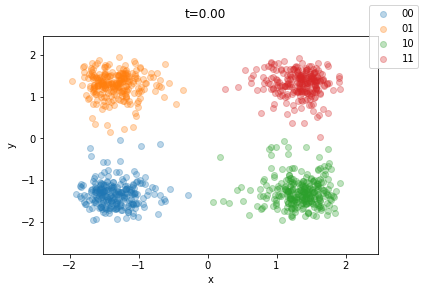

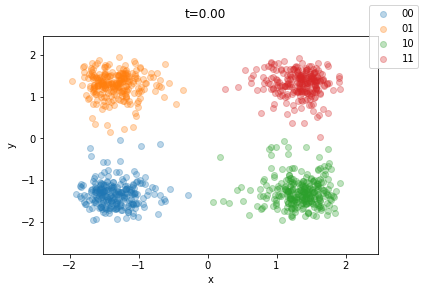

In [6]:
_time_stretch = 4
_damping = 5
_gamma = 40
_theta = 0
_eta = 10

from importlib import reload  # Python 3.4+
import helpingTools
helpingTools = reload(helpingTools)


print(f"time_stretch: {_time_stretch}, _damping: {_damping}, _gamma: {_gamma}"
      + f", _theta: {_theta}, _eta: { _eta}")
ani = helpingTools.runSimulationFunction([_time_stretch, _damping, [_gamma, _theta, _eta]], system, init_state, save = False, showAnimation = True)


In [97]:
HTML(ani.to_jshtml(fps=30))

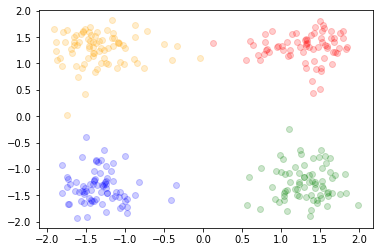

In [278]:
import helpingTools
helpingTools = reload(helpingTools)

initial_state = sim.output.all_state["states"][:, 0, :, 0]
position_categories_index_dict = helpingTools.position_classification(initial_state)

colorMapping = {"00": "blue", "01": "orange", "10": "green", "11": "red"}
helpingTools.plotColoredMapping(initial_state, position_categories_index_dict)


In [363]:
state = sim.output.all_state["states"][:, time, :, 0]
trial_request= 100
v = trial_request if trial_request else state.shape[0]

In [9]:
sim

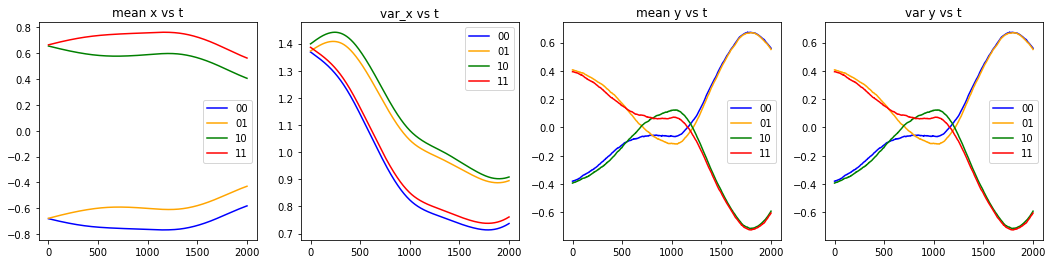

In [7]:
helpingTools.plotStatisticsChangingWithTime(sim.output.all_statistic_with_time)

In [ ]:
sim.output.all_statistic_with_time["values"].tolist()

In [64]:
sim.output.all_statistic_with_time["values"] = sim.output.all_statistic_with_time["values"].tolist()

In [67]:
import json
json.dumps(sim.output.all_statistic_with_time)

TypeError: Object of type range is not JSON serializable

In [68]:
sim.output.all_statistic_with_time

{'step_indices': range(0, 2001),
 'trial_indices': slice(None, None, None),
 'values': [[[-0.656546846605401,
    1.3952619069927026,
    -0.3856316395310078,
    -0.3856316395310078],
   [-0.6533446848466659,
    1.405533093395977,
    0.4222801722866124,
    0.4222801722866124],
   [0.6620964719429069,
    1.394029351740444,
    -0.4078531098210561,
    -0.4078531098210561],
   [0.6524994250264546,
    1.4126212696883842,
    0.3946823797957723,
    0.3946823797957723]],
  [[-0.656546846605401,
    1.3952619069927026,
    -0.3856316395310078,
    -0.3856316395310078],
   [-0.6533446848466659,
    1.405533093395977,
    0.4222801722866124,
    0.4222801722866124],
   [0.6620964719429069,
    1.394029351740444,
    -0.4078531098210561,
    -0.4078531098210561],
   [0.6524994250264546,
    1.4126212696883842,
    0.3946823797957723,
    0.3946823797957723]],
  [[-0.6567396099110461,
    1.3949901104170406,
    -0.38518145647656216,
    -0.38518145647656216],
   [-0.65313359758714,
    1

In [70]:
list(range(0, 2001))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [71]:
list(slice(None, None, None))

TypeError: 'slice' object is not iterable